In [1]:
import json, os, pickle, random
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

import qiskit
from qiskit import QuantumCircuit, execute
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.circuit.library import CXGate, RXGate, IGate, ZGate
from qiskit.providers.fake_provider import FakeMontreal, FakeLima, FakeSherbrooke

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)

from mbd_utils import cal_z_exp, generate_disorder, construct_mbl_circuit, calc_imbalance, modify_and_add_noise_to_model

import matplotlib.pyplot as plt
import seaborn as sns
from noise_utils import AddNoise

import importlib
import mlp
importlib.reload(mlp)
from mlp import MLP1, MLP2, MLP3, encode_data, encode_data_v2_ecr

In [2]:
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()

In [3]:
real_backend = provider.get_backend('ibm_brisbane')

In [4]:
fake_backend = FakeSherbrooke()

## Local
fake_backend_ideal = QasmSimulator() # Noiseless
fake_backend_noisy = AerSimulator.from_backend(fake_backend) # Noisy
stabilizer_simulator = AerSimulator(method='stabilizer')

fake_run_config_ideal = {'shots': 10000, 'backend': fake_backend_ideal, 'name': 'fake_ideal'}
fake_run_config_noisy = {'shots': 10000, 'backend': fake_backend_noisy, 'name': 'fake_noisy'}

In [4]:
import os
from tqdm.notebook import tqdm

def check_f(f, f_ext, step_indices):
    return f.endswith(f_ext) and any([f"step_%02d"%step_index in f for step_index in step_indices])

In [4]:
def load_Js(data_dir, step_indices, f_ext='.pk'):
    Js = []
    data_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if check_f(f, f_ext, step_indices)])
    for data_file in tqdm(data_files, leave=True):
        for entry in pickle.load(open(data_file, 'rb')):
            Js.append(entry['J'])
    return Js

Js = load_Js('./data/ising_zne_hardware_twirled/100q_brisbane/circuits', list(range(1, 11)))
Js = Js[::5]
print(len(Js))

  0%|          | 0/500 [00:00<?, ?it/s]

500


In [5]:
def load_circuits(data_dir, step_indices, f_ext='.pk'):
    Js = []
    circuits = []
    data_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if check_f(f, f_ext, step_indices)])
    for data_file in tqdm(data_files, leave=True):
        for entry in pickle.load(open(data_file, 'rb')):
            Js.append(entry['J'])
            circuits.append(entry['circuit'])
    return circuits, Js

In [7]:
circuits, J2 = load_circuits('./data/ising_zne_hardware/100q_brisbane/', list(range(1, 11)))

  0%|          | 0/500 [00:00<?, ?it/s]

In [7]:
Js == J2

True

In [8]:
Js = J2

In [9]:
from tqdm.notebook import tqdm
for step_index in [1]:
    with open('./zne_mitigated/twirl_100q_brisbane/step%02d.json'%step_index, 'r') as file:
        loaded = json.load(file)
    noise_factor_1 = np.array(loaded['noise_factor_1'])
    noise_factor_3 = np.array(loaded['noise_factor_3'])

for step_index in tqdm([2, 3, 4, 5, 6, 7, 8, 9, 10]):
    with open('./zne_mitigated/twirl_100q_brisbane/step%02d.json'%step_index, 'r') as file:
        loaded = json.load(file)
    noise_factor_1 = np.concatenate([noise_factor_1, loaded['noise_factor_1']])
    noise_factor_3 = np.concatenate([noise_factor_3, loaded['noise_factor_3']])

noise_factor_1_tw_avg = noise_factor_1.reshape(noise_factor_1.shape[0], 5, 5).mean(axis=-1)
noise_factor_3_tw_avg = noise_factor_3.reshape(noise_factor_3.shape[0], 5, 5).mean(axis=-1)

slope = (noise_factor_3_tw_avg - noise_factor_1_tw_avg) / 2
zne_mitigated_vals = (noise_factor_1_tw_avg - slope).tolist()
noisy_vals = noise_factor_1_tw_avg.tolist()
len(zne_mitigated_vals)

  0%|          | 0/9 [00:00<?, ?it/s]

500

In [10]:
print(len(circuits), len(zne_mitigated_vals), len(noisy_vals))

500 500 500


In [257]:
num_circ_per_step = 50
k = train_test_split = 10
train_circuits = []
train_zne_vals = []
train_noisy_vals = []
test_circuits = []
test_zne_vals = []
test_noisy_vals = []
for start_each_step in list(range(len(circuits))[::num_circ_per_step]):
    train_circuits += circuits[start_each_step:start_each_step+k]
    train_zne_vals += zne_mitigated_vals[start_each_step:start_each_step+k]
    train_noisy_vals += noisy_vals[start_each_step:start_each_step+k]
    test_circuits += circuits[start_each_step+k:start_each_step+num_circ_per_step]
    test_zne_vals += zne_mitigated_vals[start_each_step+k:start_each_step+num_circ_per_step]
    test_noisy_vals += noisy_vals[start_each_step+k:start_each_step+num_circ_per_step]

In [258]:
print(len(train_circuits), len(train_zne_vals), len(train_noisy_vals))
print(len(test_circuits), len(test_zne_vals), len(test_noisy_vals))

100 100 100
400 400 400


In [259]:
X_train, y_train = encode_data_v2_ecr(train_circuits, train_zne_vals, train_noisy_vals, obs_size=5)
X_test, y_test = encode_data_v2_ecr(test_circuits, test_zne_vals, test_noisy_vals, obs_size=5)

In [260]:
BATCH_SIZE = 32
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*1000, shuffle=False)

In [261]:
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

In [262]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
rfr_tree_list = []
for q in range(5):
    rfr = RandomForestRegressor(n_estimators=100)
    rfr.fit(X_train, y_train.iloc[:, q])
    rfr_tree_list.append(rfr)

RMSE_noisy_0: 0.06622940680866209
RMSE_mitigated_0: 0.030948046196457656
RMSE_noisy_1: 0.06571337924238625
RMSE_mitigated_1: 0.033790225657311664
RMSE_noisy_2: 0.0654646813056526
RMSE_mitigated_2: 0.033567669976810516
RMSE_noisy_3: 0.06489176308232669
RMSE_mitigated_3: 0.038460108205259816
RMSE_noisy_4: 0.06681302970392002
RMSE_mitigated_4: 0.03723788121628223
RMSE_noisy: 0.0655765734696172
RMSE_mitigated: 0.03429843037291386


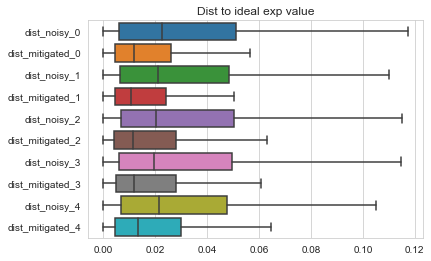

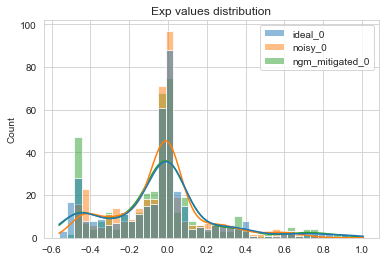

In [263]:
distances = []

num_spins = 5

for batch_X, batch_y in test_loader:
    out = []
    for q, model in enumerate(rfr_tree_list):
        out.append(model.predict(batch_X[:, :]))
    out = np.array(out).transpose()

    for ideal, noisy, ngm_mitigated in zip(
        batch_y.tolist(),
        batch_X[:, -5:].tolist(),
        out.tolist()
    ):
        for q in range(5):
            ideal_q = ideal[q]
            noisy_q = noisy[q]
            ngm_mitigated_q = ngm_mitigated[q]
            distances.append({
                f"ideal_{q}": ideal_q,
                f"noisy_{q}": noisy_q,
                f"ngm_mitigated_{q}": ngm_mitigated_q,
                f"dist_noisy_{q}": np.abs(ideal_q - noisy_q),
                f"dist_mitigated_{q}": np.abs(ideal_q - ngm_mitigated_q),
                f"dist_sq_noisy_{q}": np.square(ideal_q - noisy_q),
                f"dist_sq_mitigated_{q}": np.square(ideal_q - ngm_mitigated_q),
            })

plt.style.use({'figure.facecolor':'white'})

df = pd.DataFrame(distances)

for q in range(5):
    print(f'RMSE_noisy_{q}:', np.sqrt(df[f"dist_sq_noisy_{q}"].mean()))
    print(f'RMSE_mitigated_{q}:', np.sqrt(df[f"dist_sq_mitigated_{q}"].mean()))

print(f'RMSE_noisy:', np.sqrt(np.mean([df[f"dist_sq_noisy_{q}"].mean() for q in range(4)])))
print(f'RMSE_mitigated:', np.sqrt(np.mean([df[f"dist_sq_mitigated_{q}"].mean() for q in range(4)])))

sns.boxplot(data=df[["dist_noisy_0", "dist_mitigated_0", "dist_noisy_1", "dist_mitigated_1", "dist_noisy_2", "dist_mitigated_2", "dist_noisy_3", "dist_mitigated_3", "dist_noisy_4", "dist_mitigated_4"]], orient="h", showfliers = False)
plt.title("Dist to ideal exp value")
plt.show()

sns.histplot([df['ideal_0'], df['noisy_0'], df["ngm_mitigated_0"]], kde=True, bins=40)
plt.title("Exp values distribution")
plt.show()

In [267]:
with open('./model/mimic_zne_hardware/100q_twirl_rfr_list.pk', 'wb') as f:
    pickle.dump(rfr_tree_list, f)

In [235]:
# with open('./model/mimic_zne_hardware/100q_twirl_rfr_list.pk', 'rb') as f:
#     rfr_tree_list = pickle.load(f)

In [268]:
num_circ_per_step = 50
k = train_test_split = 10
test_circuits = []
test_zne_vals = []
test_noisy_vals = []
test_Js = []
for start_each_step in list(range(len(circuits))[::num_circ_per_step]):
    test_circuits += circuits[start_each_step+k:start_each_step+num_circ_per_step]
    test_zne_vals += zne_mitigated_vals[start_each_step+k:start_each_step+num_circ_per_step]
    test_noisy_vals += noisy_vals[start_each_step+k:start_each_step+num_circ_per_step]
    test_Js += Js[start_each_step+k:start_each_step+num_circ_per_step]

In [269]:
to_df = []
steps = np.repeat(np.arange(1, 11), num_circ_per_step-train_test_split)

models = []
with open('./model/mimic_zne_hardware/100q_twirl_rfr_list.pk', 'rb') as f:
    model = pickle.load(f)
models.append((model, 'rfr_list'))

for i, (circ_trans, noisy_exp_val, zne_mitigated, step, J) in tqdm(enumerate(zip(test_circuits, test_noisy_vals, test_zne_vals, steps, test_Js)), total=len(test_noisy_vals)):
    row = dict()
    row['noisy'] = noisy_exp_val
    row['zne_mitigated'] = zne_mitigated
    row['step'] = step
    row['J'] = J

    X, _ = encode_data_v2_ecr([circ_trans], [zne_mitigated], [noisy_exp_val], obs_size=5)

    for j, (model, name) in enumerate(models):
        if name == 'mlp':
            row[name] = model(X).tolist()[0]
        elif name == 'gnn':
            row[name] = model(entry.noisy_0,
                                    entry.observable,
                                    entry.circuit_depth,
                                    entry.x,
                                    entry.edge_index,
                                    entry.batch).tolist()[0]
        elif name in ['ols_full', 'rfr_full']:
            row[name] = model.predict(X).tolist()[0]
        elif name in ['ols', 'rfr']:
            row[name] = model.predict(X[:, -5:]).tolist()[0]
        elif name in ['rfr_list']:
            row[name] = []
            for q, m in enumerate(model):
                row[name].append(m.predict(X))
            row[name] = np.array(row[name]).transpose()[0]
        elif name in ['zne']:
            row[name] = zne_mitigated
        else:
            raise NotImplementedError

    to_df.append(row)

df = pd.DataFrame(to_df)

  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
for k in range(0, 40):
    new_df = pd.DataFrame(to_df).iloc[k::num_circ_per_step-train_test_split]

    import warnings
    warnings.filterwarnings('ignore')

    for col in new_df.columns:
        if col not in ['step']:
            new_df[f'mean_{col}'] = new_df[col].apply(np.mean)
            new_df[f'ste_{col}'] = new_df[col].apply(np.std) / np.sqrt(num_circ_per_step-train_test_split)

    plt.style.use({'figure.facecolor':'white'})
    plt.figure(figsize=(7, 5))
    steps = sorted(set(new_df.step))
    legend_labels = ['Unmitigated', 'ZNE', 'RF Mimicking ZNE']

    for i, col in enumerate(['mean_noisy', 'mean_zne_mitigated', 'mean_rfr_list']):
        plt.plot(steps, new_df[col], label=legend_labels[i], marker='o', color=f'C{i+1}')
        plt.fill_between(x=steps, y1=new_df[col]-new_df['ste_'+'_'.join(col.split('_')[1:])], y2=new_df[col]+new_df['ste_'+'_'.join(col.split('_')[1:])], alpha=0.2, color=f'C{i+1}')
    plt.title(f'{k}-th test sample with J={test_Js[k]}')
    plt.xlabel('Trotter Step')
    plt.ylabel(r'Mean')
    xmin, xmax = plt.gca().get_xlim()
    plt.xlim([xmin, xmax])
    plt.hlines(y=0, xmin=xmin, xmax=xmax, color='gray', linestyles='dashed')
    plt.legend()
    plt.grid(None)
    plt.show()

In [ ]:
# train with 25
# k =0, 7, 19
# train with 15
# k =25, 29

In [270]:
a = pd.DataFrame(to_df).iloc[30::num_circ_per_step-train_test_split]
b = pd.DataFrame(to_df).iloc[34::num_circ_per_step-train_test_split]
# c = pd.DataFrame(to_df).iloc[10::num_circ_per_step-train_test_split]
a = a.append(b)#.append(c)

In [271]:
new_df = a
for col in new_df.columns:
    if col not in ['step']:
        new_df[f'mean_{col}'] = new_df[col].apply(np.mean)
        new_df[f'ste_{col}'] = new_df[col].apply(np.std) / np.sqrt(num_circ_per_step-train_test_split)
new_df

,noisy,zne_mitigated,step,J,rfr_list,mean_noisy,ste_noisy,mean_zne_mitigated,ste_zne_mitigated,mean_J,ste_J,mean_rfr_list,ste_rfr_list
30,"[-0.44168, -0.4076000000000001, -0.40476, -0.4...","[-0.47472000000000003, -0.4586400000000001, -0...",1,0.253040,"[-0.4750827994942665, -0.46510480403900145, -0...",-0.417768,0.002098,-0.457736,0.001995,0.253040,0.0,-0.465352,0.000968
70,"[-0.35684, -0.44352, -0.3718, -0.38964, -0.3616]","[-0.4936, -0.5172000000000001, -0.488600000000...",2,0.253040,"[-0.48610400468111037, -0.47254140228033065, -...",-0.384680,0.004980,-0.491516,0.003587,0.253040,0.0,-0.466376,0.003653
110,"[0.6287200000000001, 0.6968, 0.55556, 0.666400...","[0.9231400000000001, 0.95246, 0.79322, 0.89516...",3,0.253040,"[0.7902863931655884, 0.879383202791214, 0.8235...",0.638160,0.007475,0.882452,0.008902,0.253040,0.0,0.819773,0.005007
150,"[-0.25568, -0.10816, -0.23876000000000003, -0....","[-0.33256, -0.1595, -0.28236000000000006, -0.3...",4,0.253040,"[-0.30834820210933683, -0.17136139925569296, -...",-0.231640,0.012353,-0.287740,0.012089,0.253040,0.0,-0.284964,0.009851
190,"[-0.12032000000000001, -0.14431999999999998, -...","[-0.14848, -0.14661999999999997, -0.43212, -0....",5,0.253040,"[-0.17654900163412093, -0.24339399985969068, -...",-0.204504,0.011112,-0.274600,0.018694,0.253040,0.0,-0.266492,0.009048
230,"[0.33736, 0.34680000000000005, 0.29676, 0.4481...","[0.45132, 0.4746800000000001, 0.43324000000000...",6,0.253040,"[0.4663809981942177, 0.476468408703804, 0.4716...",0.365408,0.008291,0.510848,0.011742,0.253040,0.0,0.465374,0.001596
270,"[-0.14312, -0.13451999999999997, -0.29476, -0....","[-0.16782, -0.16761999999999996, -0.4082400000...",7,0.253040,"[-0.20897060081362726, -0.20792059794068338, -...",-0.192112,0.010272,-0.252864,0.014207,0.253040,0.0,-0.252510,0.009306
310,"[-0.16443999999999998, -0.0964, -0.2306, -0.10...","[-0.20121999999999995, -0.14536, -0.31938, -0....",8,0.253040,"[-0.20258380137383938, -0.13462439954280853, -...",-0.143920,0.007761,-0.189080,0.010973,0.253040,0.0,-0.177744,0.005039
350,"[0.21791999999999997, 0.22560000000000002, 0.1...","[0.30169999999999997, 0.32614000000000004, 0.1...",9,0.253040,"[0.2305519986897707, 0.21946660295128823, 0.18...",0.172296,0.006770,0.235148,0.010830,0.253040,0.0,0.211678,0.002542
390,"[-0.17936000000000002, 0.0006399999999999989, ...","[-0.26272, 0.024099999999999996, -0.0023000000...",10,0.253040,"[-0.19365080047398806, -0.004283000048599206, ...",-0.050584,0.010776,-0.071040,0.016055,0.253040,0.0,-0.072292,0.011438


In [272]:
df_to_plot = []
for i, row in new_df.iterrows():
    df_to_plot.append([row['mean_noisy'], row['ste_noisy'], 'Unmitigated', row['step'], f"J/h={round(row['J']/(0.66*np.pi), 2)}", row['J']])
    df_to_plot.append([row['mean_zne_mitigated'], row['ste_zne_mitigated'], 'ZNE', row['step'], f"J/h={round(row['J']/(0.66*np.pi), 2)}", row['J']])
    df_to_plot.append([row['mean_rfr_list'], row['ste_rfr_list'], 'RF Mimicking ZNE', row['step'], f"J/h={round(row['J']/(0.66*np.pi), 2)}", row['J']])
df_to_plot = pd.DataFrame(df_to_plot)

In [273]:
df_to_plot.columns = ['mean', 'ste', 'QEM', 'step', 'J/h', 'J']
df_to_plot

,mean,ste,QEM,step,J/h,J
0,-0.417768,0.002098,Unmitigated,1,J/h=0.12,0.253040
1,-0.457736,0.001995,ZNE,1,J/h=0.12,0.253040
2,-0.465352,0.000968,RF Mimicking ZNE,1,J/h=0.12,0.253040
3,-0.384680,0.004980,Unmitigated,2,J/h=0.12,0.253040
4,-0.491516,0.003587,ZNE,2,J/h=0.12,0.253040
5,-0.466376,0.003653,RF Mimicking ZNE,2,J/h=0.12,0.253040
6,0.638160,0.007475,Unmitigated,3,J/h=0.12,0.253040
7,0.882452,0.008902,ZNE,3,J/h=0.12,0.253040
8,0.819773,0.005007,RF Mimicking ZNE,3,J/h=0.12,0.253040
9,-0.231640,0.012353,Unmitigated,4,J/h=0.12,0.253040


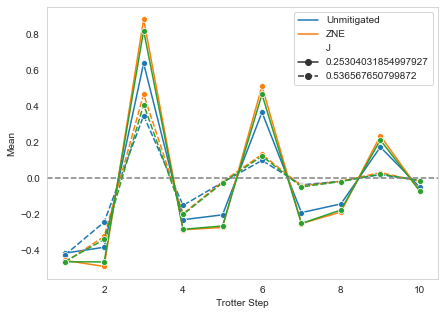

In [274]:
plt.style.use({'figure.facecolor':'white'})
plt.figure(figsize=(7, 5))
steps = sorted(set(df_to_plot.step))
legend_labels = ['ZNE', 'RF Mimicking ZNE']

# for J, df in new_df.groupby('J'):
#     for i, col in enumerate(['mean_zne_mitigated', 'mean_rfr_list']):
#         plt.plot(steps, df[col], label=legend_labels[i], marker='o', color=f'C{i+1}')
#         plt.fill_between(x=steps, y1=df[col]-df['ste_'+'_'.join(col.split('_')[1:])], y2=df[col]+df['ste_'+'_'.join(col.split('_')[1:])], alpha=0.2, color=f'C{i+1}')

sns.lineplot(data=df_to_plot, x='step', y='mean', style='J', hue='QEM', markers='o')
plt.xlabel('Trotter Step')
plt.ylabel(r'Mean')
xmin, xmax = plt.gca().get_xlim()
plt.xlim([xmin, xmax])
plt.hlines(y=0, xmin=xmin, xmax=xmax, color='gray', linestyles='dashed')
plt.legend()
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:3]+handles[4:], labels=labels[1:3]+labels[4:])
plt.grid(None)
plt.show()

In [277]:
df_to_plot.to_pickle('/Users/haoranliao/GitHub/blackwater/docs/paper_figures/mimic_zne_hardware_over_steps.pk')

In [278]:
df = pd.DataFrame(to_df)
df.to_pickle('/Users/haoranliao/GitHub/blackwater/docs/paper_figures/mimic_zne_hardware.pk')

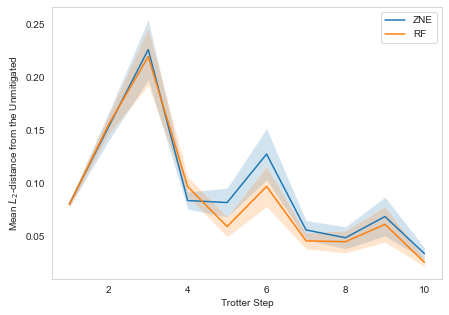

In [275]:
df = pd.DataFrame(to_df)
new_df = df
# new_df = df.iloc[[i for range_start in range(0, len(df), 60) for i in range(range_start+30, range_start+60)]]
# new_df = df.iloc[[i for range_start in range(30, len(df), 60) for i in range(range_start, range_start+30)]]

import warnings
warnings.filterwarnings('ignore')

def l2_dist(list1, list2):
    return np.sqrt(np.sum([(a - b)**2 for a, b in zip(list1, list2)]))

for col in new_df.columns:
    if col not in ['step', 'noisy', 'J']:
        new_df[f'L2_{col}'] = new_df.apply(lambda row: l2_dist(row['noisy'], row[col]), axis=1)

new_df_mean = new_df.groupby('step').agg('mean')
new_df_ste = new_df.groupby('step').agg('std') / np.sqrt(num_circ_per_step-train_test_split)

plt.style.use({'figure.facecolor':'white'})
plt.figure(figsize=(7, 5))
steps = sorted(set(new_df.step))
legend_labels = ['ZNE', 'RF']
for i, col in enumerate(['L2_zne_mitigated', 'L2_rfr_list']):
    plt.plot(steps, new_df_mean[col], label=legend_labels[i])
    plt.fill_between(x=steps, y1=new_df_mean[col]-new_df_ste[col], y2=new_df_mean[col]+new_df_ste[col], alpha=0.2)
plt.xlabel('Trotter Step')
plt.ylabel(r'Mean $L_2$-distance from the Unmitigated')
plt.legend()
plt.grid(None)
plt.show()

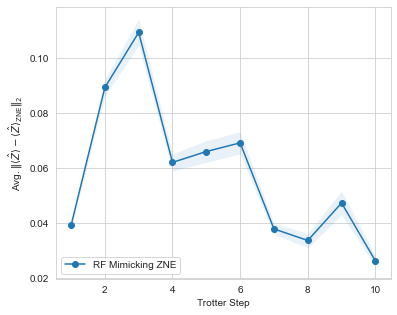

In [276]:
df = pd.DataFrame(to_df)
new_df = df

for col in new_df.columns:
    if col not in ['step', 'noisy', 'J', 'zne_mitigated']:
        new_df[f'L2_{col}'] = new_df.apply(lambda row: l2_dist(row['zne_mitigated'], row[col]), axis=1)

df_mimic_zne_mean = new_df.groupby('step').agg('mean')
df_mimic_zne_ste = new_df.groupby('step').agg('std') / np.sqrt((num_circ_per_step-train_test_split)*5)

plt.style.use({'figure.facecolor':'white'})
plt.figure(figsize=(6, 5))
a = plt.gca()
steps = sorted(set(new_df.step))
legend_labels = ['RF Mimicking ZNE']#, 'Ideal', 'Unmitigated']
for i, col in enumerate(['L2_rfr_list']):
    plt.plot(steps, df_mimic_zne_mean[col], label=legend_labels[i], marker='o')
    plt.fill_between(x=steps, y1=df_mimic_zne_mean[col]-df_mimic_zne_ste[col], y2=df_mimic_zne_mean[col]+df_mimic_zne_ste[col], alpha=0.1)
plt.xlabel('Trotter Step')
plt.ylabel(r'Avg. $\Vert \langle \hat{Z} \rangle - \langle \hat{Z} \rangle_{\mathrm{ZNE}} \Vert_2$')
plt.legend(loc='lower left')

plt.show()